# Nasa Kepler Exoplanet Search Data

This is a dataset collected by the Kepler Space Observatory, a NASA built satellite launched in 2009 dedicated to searching for exoplanets, with the ultimate goal of finding habitable planets. An exoplanet is a planet that is not located in our solar system. The data consists of almost 10,000 Kelper Objects of Interest (KOI's) which are the exoplanet candidates that Kepler has taken observations on. You can find the original dataset here: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative

The goal of this project is to create a model that accurately predicts whether a KOI is a **CANDIDATE** for further investigation or a **FALSE POSITIVE**. The Kepler mission finds exoplanets by observing transit events on target stars. A transit event is when a planet passes between a star and its observer (in this case the Kepler telescope). When this happens, the target star's light dims ever so slightly. However, this doesn't always mean that an exoplanet is what caused the star to dim. **FALSE POSITIVES** are detections of transit-like signals present in the data that are actually not due to planetary transits. This usually happens because of Ecclipsing Binaries. This when the transit-like event is caused from a star passing in front or behind of the original target star, tampering with the light signals enough to mimic a planetary transit. My goal is to use the data to decipher when a transit-like event is a **FALSE POSTIIVE** or an exoplanet **CANDIDATE** ready for further investigation. 

In [37]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tabulate import tabulate

# Exploratory Data Analysis
### Let's read in our data using pandas

In [ ]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('exoplanet_data.csv')

print(df.head(5))  
df.shape

We have 9564 observations and 50 columns. Let's take a look at all of our columns:

In [39]:
df.columns

Index(['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
       'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
       'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth',
       'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol',
       'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')

As you can see most of these are error terms indicating the lower and upper bounds of each individual feature such as 'koi_impact_err1' and 'koi_impact_err2'. For our purposes, we just need the original observation such as 'koi_impact'. So let's get rid of the error terms as well as the Kepler ID's and names since this will have no affect on whether or not a KOI is an exoplanet.

In [40]:
# Don't need the error columns
columns_to_delete = ['koi_teq_err1', 'koi_teq_err2', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration_err1', 'koi_duration_err2',
                     'koi_depth_err1', 'koi_depth_err2', 'koi_prad_err1', 'koi_prad_err2', 'koi_insol_err1', 'koi_insol_err2', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg_err1', 'koi_slogg_err2',
                     'koi_srad_err1', 'koi_srad_err2', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_kepmag', 'kepler_name', 'koi_score', 'rowid', 'kepid', 'kepoi_name', 'koi_disposition']
df.drop(columns_to_delete, axis=1, inplace=True)

Now let's take a look at whether our dataset is balanced or not, meaning if we have the around the same number of **FALSE POSITIVES** and **CANDIDATES**.

In [41]:
df['koi_pdisposition'].value_counts(normalize=True)
# Our outcomes are balanced so we can continue preparing the dataset for training

koi_pdisposition
FALSE POSITIVE    0.529904
CANDIDATE         0.470096
Name: proportion, dtype: float64

As you can see, our dataset is balanced with roughly 53% of the observations being **FALSE POSITIVES** and 47% being **CANDIDATES**.

Our label (the variable we are trying to predict) is koi_pdisposition which takes the values **FALSE POSITIVE** or **CANDIDATE**. Now instead of our label value being an object, lets convert it into an integer value, either 0 (FALSE POSITIVE) or 1 (CANDIDATE). 

In [42]:
# Convert 'koi_pdisposition' into numeric feature where 0 represents FALSE POSITIVE and 1 represents CANDIDATE
df['koi_pdisposition'] = df['koi_pdisposition'].map({'FALSE POSITIVE': 0, 'CANDIDATE': 1})
df.head(5)

,koi_pdisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_slogg,koi_srad,ra,dec
0,1,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,5455.0,4.467,0.927,291.93423,48.141651
1,1,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,5455.0,4.467,0.927,291.93423,48.141651
2,0,0,1,0,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,76.3,5853.0,4.544,0.868,297.00482,48.134129
3,0,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,5805.0,4.564,0.791,285.53461,48.285210
4,1,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,6031.0,4.438,1.046,288.75488,48.226200


## Missing Values

Let's check how many null values are in our dataset.

In [43]:
missing_values = df.isnull().sum()
print(missing_values)

koi_pdisposition      0
koi_fpflag_nt         0
koi_fpflag_ss         0
koi_fpflag_co         0
koi_fpflag_ec         0
koi_period            0
koi_time0bk           0
koi_impact          363
koi_duration          0
koi_depth           363
koi_prad            363
koi_teq             363
koi_insol           321
koi_model_snr       363
koi_steff           363
koi_slogg           363
koi_srad            363
ra                    0
dec                   0
dtype: int64


Most of the features from koi_impact to koi_srad have 363 null values which only makes up 3.7% of the total data. My initial instinct is to delete all of the observations with null values to get a clean dataset. However, this might get rid of important information. Let's see how many of these null values are **CANDIDATE** versus **FALSE POSITIVE**. 

In [44]:
count = ((df.koi_impact.isnull()) & (df.koi_depth.isnull()) & (df.koi_prad.isnull()) & (df.koi_teq.isnull()) & (df.koi_insol.isnull()) & (df.koi_model_snr.isnull()) & 
        (df.koi_steff.isnull()) & (df.koi_slogg.isnull()) & (df.koi_depth.isnull()) & (df.koi_pdisposition == 0)).sum()
print(count)

259


So there are 259 observations (out of 363) where all of these features are null when koi_pdisposition is **FALSE POSITIVE**. This means that 71% of the null values occur when koi_pdisposition is **FALSE POSITIVE**. If we were to delete all null values from the dataset, we would be deleting a disproportionate amount of **FALSE POSITIVE**'s. This is why I believe we should replace the null values with either the mean or the median. To determine which metric, we need to look at the distribution of the features.

## Numeric Feature Analysis
Let's look at the distribution of each feature we are interested in using histograms. 

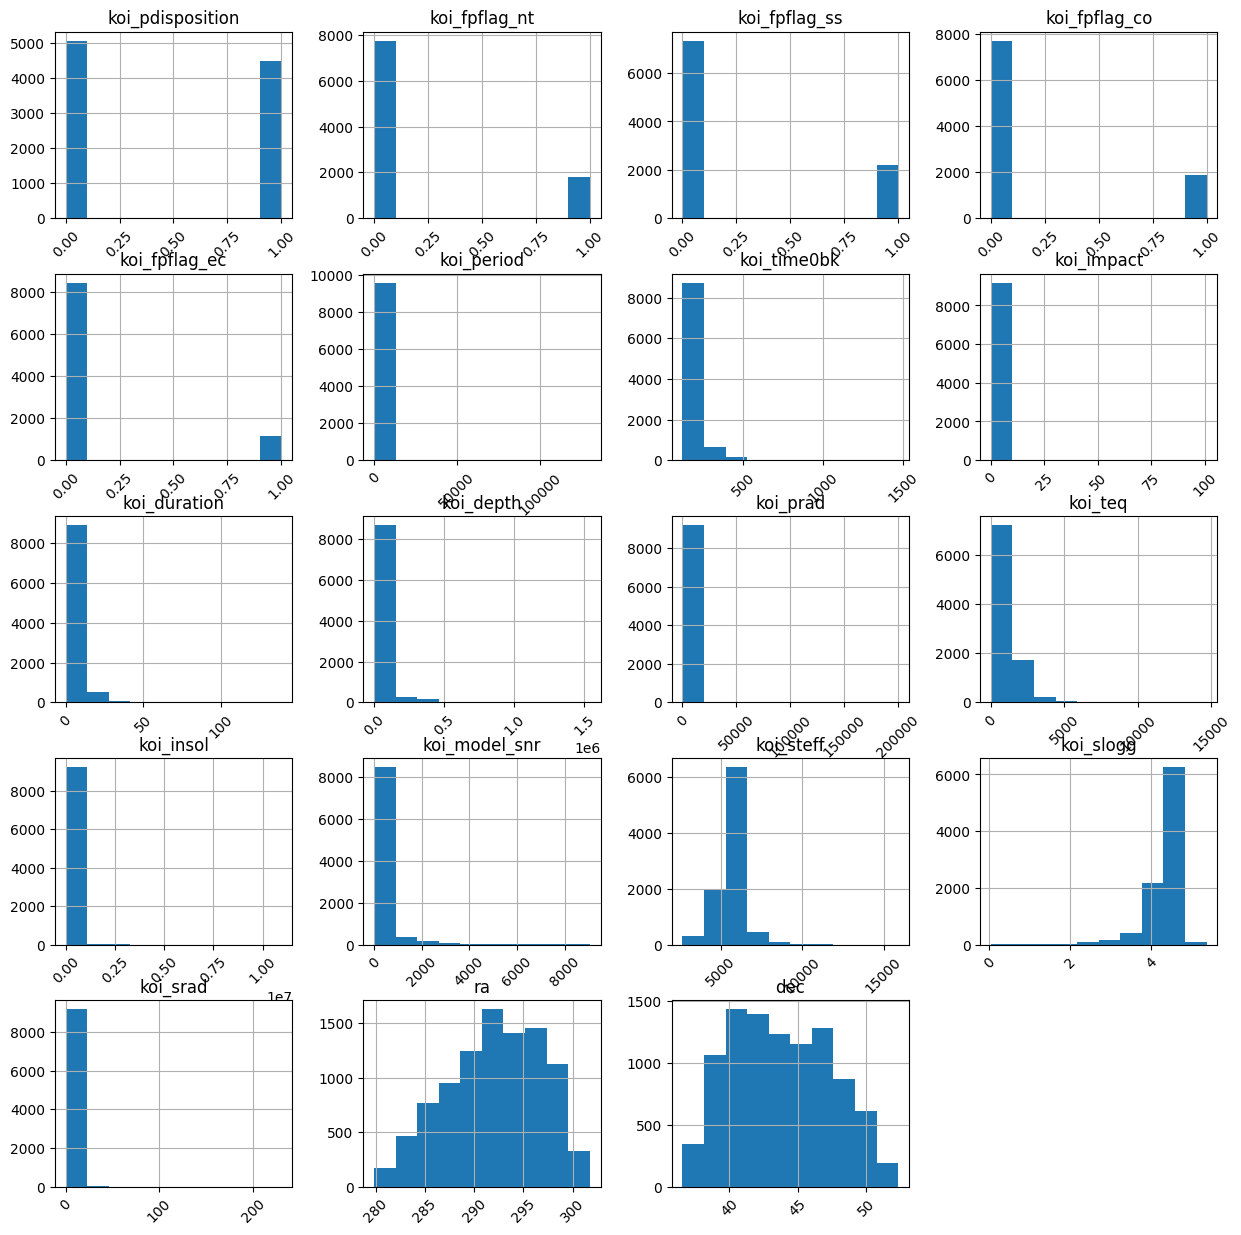

In [45]:
df.hist(figsize=(15,15), xrot=45)
plt.show()

Koi_pdistribution, koi_fpflag_nt, koi_fpflag_ss, koi_fpflag_co, and koi_fpflag_ec are all binary variables which is why the bins are either a 0 or 1. For most of the other variables, there is one large bin on the left and then almost no data to the right of it. This suggests that the data is skewed due to large outliers. This can be shown in more detail below:

In [46]:
df.describe()

,koi_pdisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_slogg,koi_srad,ra,dec
count,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9201.000000,9564.000000,9.201000e+03,9201.000000,9201.000000,9.243000e+03,9201.000000,9201.000000,9201.000000,9201.000000,9564.000000,9564.000000
mean,0.470096,0.188206,0.231598,0.194898,0.120033,75.671358,166.183251,0.735105,5.621606,2.379134e+04,102.891778,1085.385828,7.745737e+03,259.895001,5706.823280,4.310157,1.728712,292.060163,43.810433
std,0.499131,0.390897,0.421875,0.396143,0.325018,1334.744046,67.918960,3.348832,6.471554,8.224268e+04,3077.639126,856.351161,1.592047e+05,795.806615,796.857947,0.432606,6.127185,4.766657,3.601243
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,120.515914,0.000000,0.052000,0.000000e+00,0.080000,25.000000,0.000000e+00,0.000000,2661.000000,0.047000,0.109000,279.852720,36.577381
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,132.761718,0.197000,2.437750,1.599000e+02,1.400000,539.000000,2.015000e+01,12.000000,5310.000000,4.218000,0.829000,288.660770,40.777173
50%,0.000000,0.000000,0.000000,0.000000,0.000000,9.752831,137.224595,0.537000,3.792600,4.211000e+02,2.390000,878.000000,1.416000e+02,23.000000,5767.000000,4.438000,1.000000,292.261125,43.677504
75%,1.000000,0.000000,0.000000,0.000000,0.000000,40.715178,170.694603,0.889000,6.276500,1.473400e+03,14.930000,1379.000000,8.702900e+02,78.000000,6112.000000,4.543000,1.345000,295.859160,46.714611
max,1.000000,1.000000,1.000000,1.000000,1.000000,129995.778400,1472.522306,100.806000,138.540000,1.541400e+06,200346.000000,14667.000000,1.094755e+07,9054.700000,15896.000000,5.364000,229.908000,301.720760,52.336010


When comparing the mean to the max for most of these features there are huge discrepanices. For example, look at koi_period which has a mean value of 75.7 and a max value of 129995.8, a massive difference! This occurs for the majority of these numeric features, letting us know that most of the data is skewed to the right. Taking a closer look at the outlier observations suggests that it wasn't data entry error and that these observations do have a real possibility of occuring. Thus, it would be bad practice to get rid of these outliers because they could happen again. 

This analysis tells us that we should replace the null values with the median of each feature instead of the mean because of the heavy skew. Median is more resistant to skew, giving us a better idea of the data that will usually occur.  

In [47]:
# Replacing the null values with the averages of each feature for when it's a FALSE POSITIVE or CANDIDATE
# Would rather do this than get rid of the rows themselves because the majority of the null values are when the koi_pdisposiiton is FALSE POSITIVE
condition_FP = df['koi_pdisposition'] == 0
condition_C = df['koi_pdisposition'] == 1

# koi_impact
median_impact_FP = df.loc[condition_FP, 'koi_impact'].median()
df.loc[condition_FP, 'koi_impact'] = df.loc[condition_FP, 'koi_impact'].fillna(median_impact_FP)
                                                                                     
median_impact_C = df.loc[condition_C, 'koi_impact'].median()
df.loc[condition_C, 'koi_impact'] = df.loc[condition_C, 'koi_impact'].fillna(median_impact_C)

# koi_depth
median_depth_FP = df.loc[condition_FP, 'koi_depth'].median()
df.loc[condition_FP, 'koi_depth'] = df.loc[condition_FP, 'koi_depth'].fillna(median_depth_FP)
                                                                                     
median_depth_C = df.loc[condition_C, 'koi_depth'].median()
df.loc[condition_C, 'koi_depth'] = df.loc[condition_C, 'koi_depth'].fillna(median_depth_C)

# koi_prad
median_prad_FP = df.loc[condition_FP, 'koi_prad'].median()
df.loc[condition_FP, 'koi_prad'] = df.loc[condition_FP, 'koi_prad'].fillna(median_prad_FP)
                                                                                     
median_prad_C = df.loc[condition_C, 'koi_prad'].median()
df.loc[condition_C, 'koi_prad'] = df.loc[condition_C, 'koi_prad'].fillna(median_prad_C)

# koi_teq
median_teq_FP = df.loc[condition_FP, 'koi_teq'].median()
df.loc[condition_FP, 'koi_teq'] = df.loc[condition_FP, 'koi_teq'].fillna(median_teq_FP)
                                                                                     
median_teq_C = df.loc[condition_C, 'koi_teq'].median()
df.loc[condition_C, 'koi_teq'] = df.loc[condition_C, 'koi_teq'].fillna(median_teq_C)

# koi_insol
median_insol_FP = df.loc[condition_FP, 'koi_insol'].median()
df.loc[condition_FP, 'koi_insol'] = df.loc[condition_FP, 'koi_insol'].fillna(median_insol_FP)
                                                                                     
median_insol_C = df.loc[condition_C, 'koi_insol'].median()
df.loc[condition_C, 'koi_insol'] = df.loc[condition_C, 'koi_insol'].fillna(median_insol_C)

# koi_model_snr
median_model_snr_FP = df.loc[condition_FP, 'koi_model_snr'].median()
df.loc[condition_FP, 'koi_model_snr'] = df.loc[condition_FP, 'koi_model_snr'].fillna(median_model_snr_FP)
                                                                                     
median_model_snr_C = df.loc[condition_C, 'koi_model_snr'].median()
df.loc[condition_C, 'koi_model_snr'] = df.loc[condition_C, 'koi_model_snr'].fillna(median_model_snr_C)

# koi_steff
median_steff_FP = df.loc[condition_FP, 'koi_steff'].median()
df.loc[condition_FP, 'koi_steff'] = df.loc[condition_FP, 'koi_steff'].fillna(median_steff_FP)
                                                                                     
median_steff_C = df.loc[condition_C, 'koi_steff'].median()
df.loc[condition_C, 'koi_steff'] = df.loc[condition_C, 'koi_steff'].fillna(median_steff_C)

# koi_slogg 
median_slogg_FP = df.loc[condition_FP, 'koi_slogg'].median()
df.loc[condition_FP, 'koi_slogg'] = df.loc[condition_FP, 'koi_slogg'].fillna(median_slogg_FP)
                                                                                     
median_slogg_C = df.loc[condition_C, 'koi_slogg'].median()
df.loc[condition_C, 'koi_slogg'] = df.loc[condition_C, 'koi_slogg'].fillna(median_slogg_C)

# koi_srad 
median_srad_FP = df.loc[condition_FP, 'koi_srad'].median()
df.loc[condition_FP, 'koi_srad'] = df.loc[condition_FP, 'koi_srad'].fillna(median_srad_FP)
                                                                                     
median_srad_C = df.loc[condition_C, 'koi_srad'].median()
df.loc[condition_C, 'koi_srad'] = df.loc[condition_C, 'koi_srad'].fillna(median_srad_C)

In [48]:
missing_values = df.isnull().sum()
print(missing_values)
df.columns

koi_pdisposition    0
koi_fpflag_nt       0
koi_fpflag_ss       0
koi_fpflag_co       0
koi_fpflag_ec       0
koi_period          0
koi_time0bk         0
koi_impact          0
koi_duration        0
koi_depth           0
koi_prad            0
koi_teq             0
koi_insol           0
koi_model_snr       0
koi_steff           0
koi_slogg           0
koi_srad            0
ra                  0
dec                 0
dtype: int64


Index(['koi_pdisposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol',
       'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad', 'ra', 'dec'],
      dtype='object')

We've now replaced all of our null values with the median value of each feature. We can move on to analyzing the binary features.

## Binary Features Analysis
Let's take a look at the distribution of each binary feature:

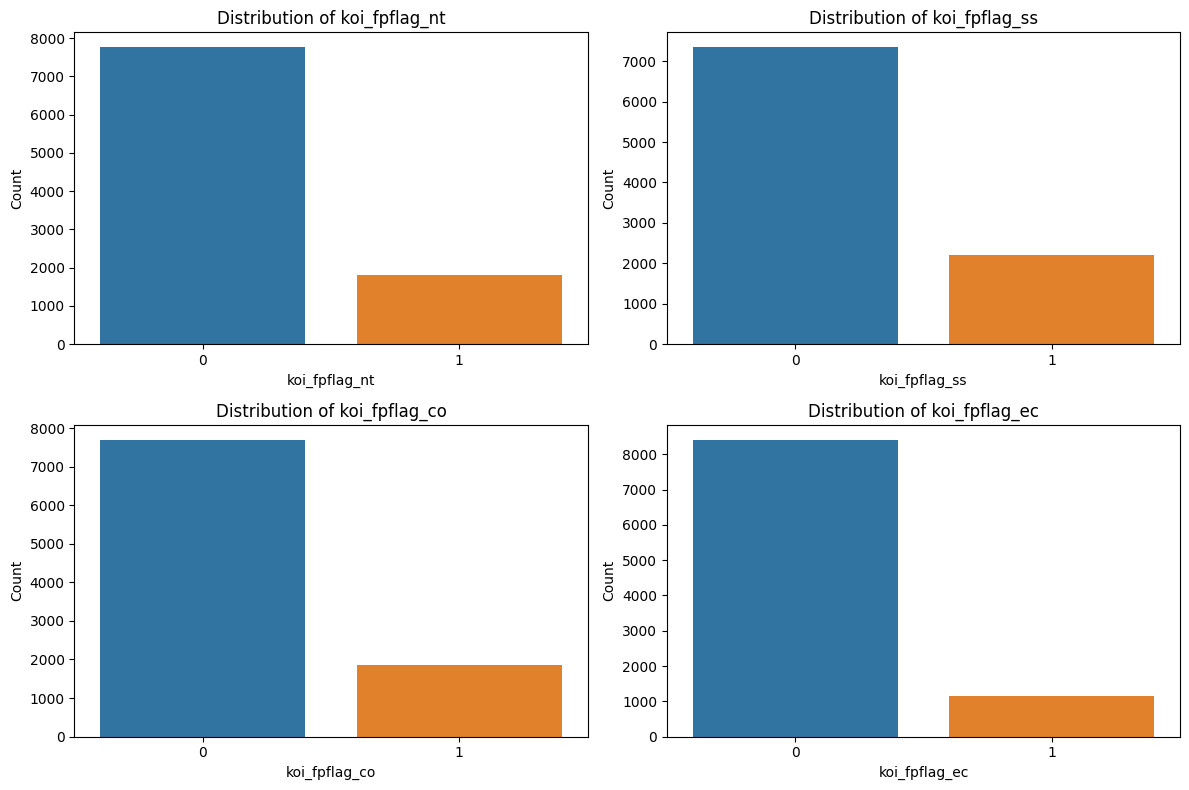

In [49]:
# Distribution Analysis
binary_features = ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Flatten the axes array to handle varying numbers of subplots
axes = axes.flatten()

# Loop through the binary features and plot them
for i, feature in enumerate(binary_features):
    ax = axes[i]
    sns.countplot(x=feature, data=df, ax=ax)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

These four features are all flag variables. This means that NASA has flagged the observation because something out of the ordinary occured. And as you can see from the plots, this doesn't happen very often. Now let's see how each of these features relate our target variable:

In [50]:
# Relationship with Target Variable
for feature in binary_features:
    print(f"Cross-tabulation of {'koi_pdisposition'} and {feature}")
    display(pd.crosstab(df['koi_pdisposition'], df[feature], margins=True, margins_name = 'Total'))
    print()
    

Cross-tabulation of koi_pdisposition and koi_fpflag_nt


koi_fpflag_nt,0,1,Total
koi_pdisposition,,,
0,3268,1800,5068
1,4496,0,4496
Total,7764,1800,9564



Cross-tabulation of koi_pdisposition and koi_fpflag_ss


koi_fpflag_ss,0,1,Total
koi_pdisposition,,,
0,2895,2173,5068
1,4454,42,4496
Total,7349,2215,9564



Cross-tabulation of koi_pdisposition and koi_fpflag_co


koi_fpflag_co,0,1,Total
koi_pdisposition,,,
0,3204,1864,5068
1,4496,0,4496
Total,7700,1864,9564



Cross-tabulation of koi_pdisposition and koi_fpflag_ec


koi_fpflag_ec,0,1,Total
koi_pdisposition,,,
0,3920,1148,5068
1,4496,0,4496
Total,8416,1148,9564


Here are four cross-tabulation tables for each of the flag features. The 0 and 1 at the top of each table correspond to the value of each flag feature. The tables show the count of observations that fall into the various combinatoins of categories for the two variables. The most important information provided from these tables are when the flag features are a 1. For all the flag features except koi_fpflag_ss, when the feature value is a 1, the koi_pdisposition value is ALWAYS a **FALSE POSITIVE**. And even for koi_fpflag_ss, 98% of the time when it is a 1, the koi_pdisposition is **FALSE POSITIVE**. This result is telling us that for the most part when an observation gets flagged (in any of the four cases) that observation is a **FALSE POSITIVE**. This will be good to know when constructing our model since this will likely be an important feature. 

## Target Relationship with Numeric Features
Here, we will separate the data by the label to see if there are any patterns in the features relating to **FALSE POSITIVE**'s and **CANDIDATE**'s. We will use Seaborn's boxplot which will display a five number summary of each feature separated by koi_pdisposition. 

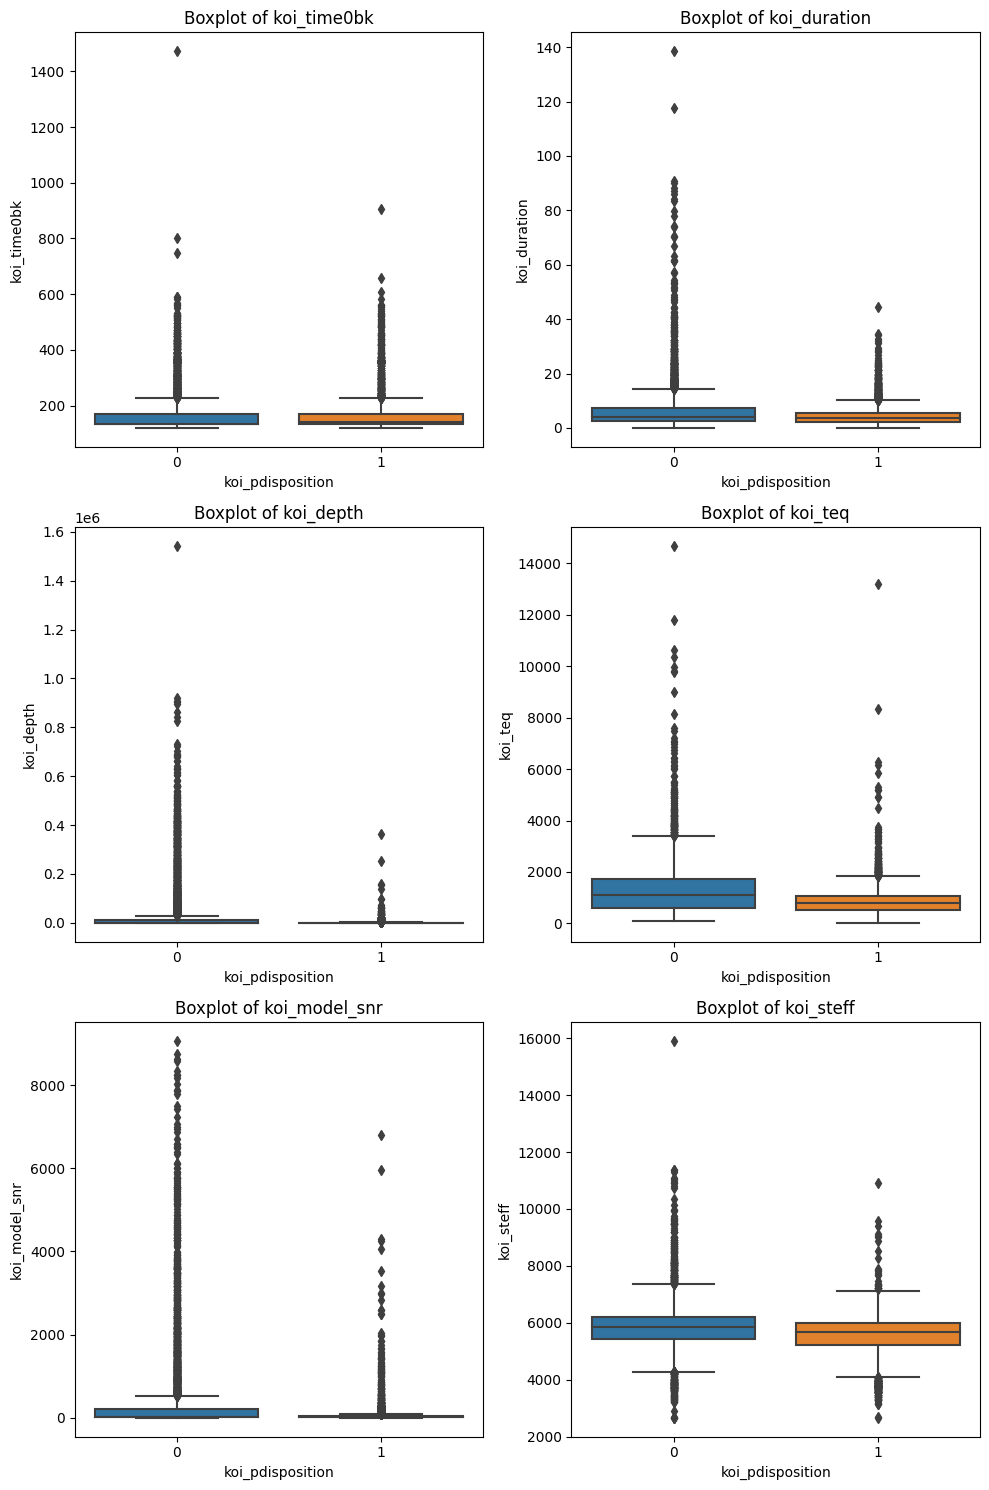

In [71]:
# Boxplots for all our numeric data to see if there are any patterns relating to Candidates and False Positives
num_features = ['koi_time0bk','koi_duration', 'koi_depth', 'koi_teq', 'koi_model_snr', 'koi_steff']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through numerical features
for i, col in enumerate(num_features):
    # Create a boxplot for each feature in the appropriate subplot
    sns.boxplot(x='koi_pdisposition', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('koi_pdisposition')
    axes[i].set_ylabel(col)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
    
# the largest differences between CANDIDATES and FALSE POSITIVES seemed to be 'koi_impact', 'koi_duration', 'koi_depth', 'koi_teq', and 'koi_model_snr'
# These might be good ideas for predictors 

We see that koi_time0bk and koi_steff are roughly equally distributed between **FALSE POSITIVE**'s and **CANDIDATE**'s so they might not be a great predictor for koi_pdisposition. However, the features with larger differences in distributions include koi_duration, koi_depth, koi_teq, and koi_model_snr which might be better predictors. I only included the variables where relevant analysis could take place. The others had outliers that were too large to deduce anything about the boxplot. 

## Correlation Matrix for Numeric Features

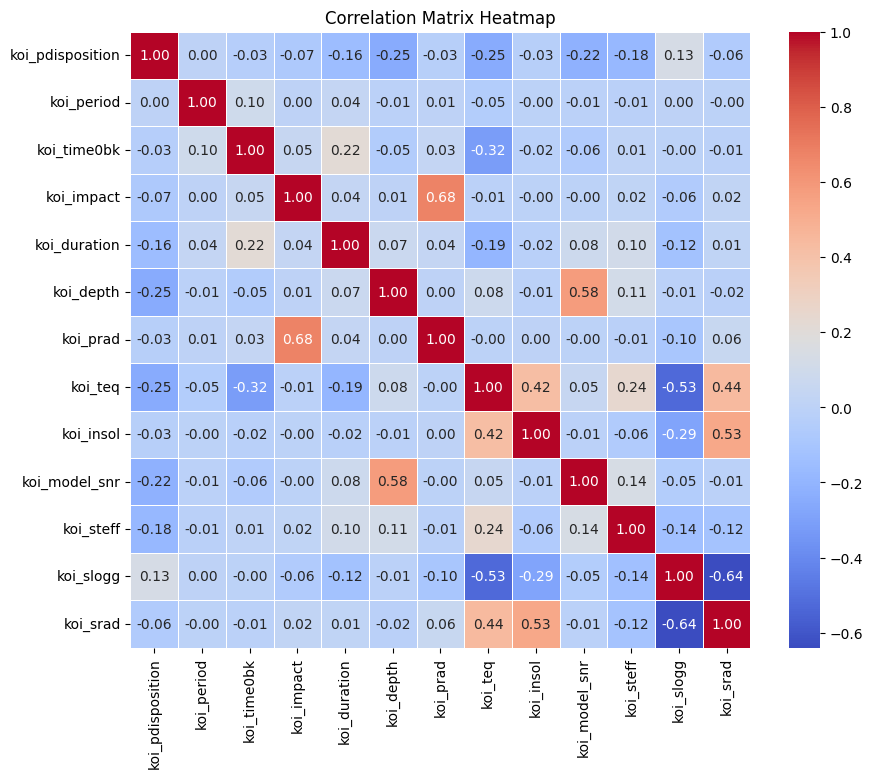

In [52]:
# Pearson Correlation matrix
cont_vars = ['koi_pdisposition', 'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad']
corr_matrix = df[cont_vars].corr()

# Heatmap of correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidth=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Note that koi_prad and koi_impact have the highest positive correlation at 0.68. This is interesing because koi_prad is the planetary radius and koi_impact is the distance between the center of the star and the center of the planetary object. As planetary radius increases, its distance from the star tends to increase as well.

Also, koi_srad and koi_slogg have the largest negative correlation at -0.64. Koi_srad is the radius of the star and koi_slogg is the base-10 logarithm of the acceleration due to gravity at the surface of the star. So as the radius of the star increases, the acceleration due to gravity at the surface tends to decrease. This didn't make sense because shouldn't a larger object generally have more gravity? I did some research and found out that in stars, radius and mass are not neccessarily proportional. As stars become larger, then can also become less dense, resulting in a lower surface gravity for larger stars. As stars evolve, their radius can change while their mass remains constant leading to a smaller surface gravity. 

The highest correlations with our label ('koi_pdisposition') is koi_depth with a weak negative correlation of -0.27 and koi_teq with a weak negative correlation of -0.26. Koi_depth is the fraction of stellar flux (change in brightness) at the start of the planetary transit. This can also be thought of as the ratio of the area of the planet to area of the star. A negative correlation means that as 'koi_pdisposition' increases (moving from FALSE POSITIVE to CANDIDATE), koi_depth tends to decrease slightly. Basically, there is a weak tendency for CANDIDATE exoplanets to have a slightly lower transit depth than exoplanets classified as FALSE POSITIVE. Koi_teq is an approximate temperature of the exoplanet. A negative corrleation of -0.26 means that there is a weak tendency for CANDIDATE exoplanets to have a slightly lower temperature than exoplanets classified as FALSE POSITIVE. 

That concludes our Exploratory Data Analysis. Now we can save our cleaned data and prepare for modeling. 

In [53]:
df.to_csv('data_cleaned.csv', index=False)